In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics
"""
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

!unzip train-images.zip
!unzip test-images.zip

"""






'\n# downloading the images\n\n!wget https://challengedata.ens.fr/media/public/train-images.zip\n!wget https://challengedata.ens.fr/media/public/test-images.zip\n!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv\n\n!unzip train-images.zip\n!unzip test-images.zip\n\n'

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

PATH ='/content/drive/MyDrive/Raidium_challenge/'

Mounted at /content/drive


In [3]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv(PATH + "y_train.csv", index_col=0).T

In [4]:
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import models, datasets, transforms
import os
import glob
from PIL import Image


In [5]:
import re
def alphanumeric_sort(name):
    parts = re.split('(\d+)', name)
    return [int(part) if part.isdigit() else part for part in parts]



In [6]:
class CTDataset(Dataset):
  def __init__(self,path,transform=None):
    self.filenames = sorted(glob.glob(os.path.join(path, '**/*.png'),recursive = True),key=alphanumeric_sort)
    self.transform = transform
    dataset_list = []
    for image_file in self.filenames:
        dataset_list.append(Image.open(image_file).convert("RGB"))
    self.imgs = np.stack(dataset_list, axis=0)


  def __getitem__(self, index):
    img_path=self.filenames[index]
    #label = self.filenames[index].split("/")[-2]
    img = Image.open(img_path).convert("RGB")
    if self.transform is not None:
      img=self.transform(img)
    return img, img_path


  def __len__(self):
    return len(self.imgs)



In [ ]:
batch_size = 1
dataset = CTDataset(PATH + "train-images")
dl = DataLoader(dataset, batch_size=batch_size)


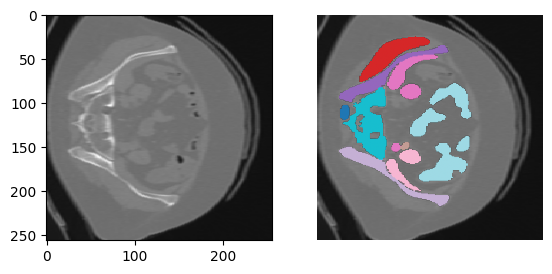

In [ ]:
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256, 256)) == 0, (seg.reshape((256, 256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

plot_slice_seg(dataset.imgs[0], labels_train.iloc[0].values.reshape((256, 256)))

In [ ]:
index_thorax=[304,305,327,331,415,418,114]
index_cuisse =[1578,1579,1779,1654,1655,393]
index_pelvis = [115, 243, 295, 342,279]
index_bizarre = [1648,1649,1653,1652,1711,1712,1849]
index_tete=[1679,1702,1736,1737,1601,1616,99,102,103]
index_abdo3=[69,70]
index_abdo4=[80,81]
index_abdo2=[0,6,75]

index_chepa=[1623,1624,1768,1769,1783,1784,106,107,108,109,110,111]



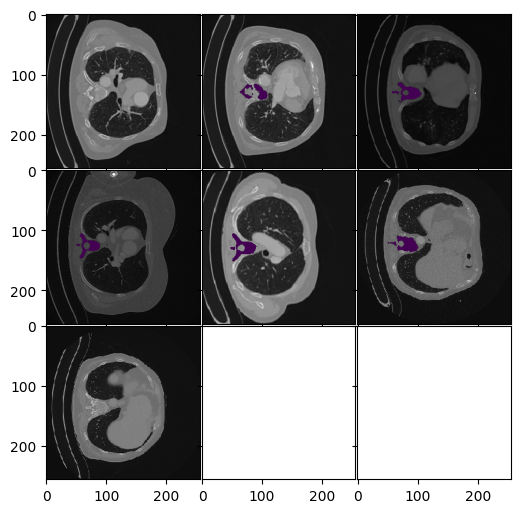

In [ ]:
def visu_index(index_img, index):
  nrows = len(index_img) //3 +1
  fig =plt.figure(figsize=(6,9))
  grid = ImageGrid(fig,111, (nrows,3))
  for ax,im in zip(grid, index_img):
    ax.imshow(dataset.imgs[im], cmap="gray")
    seg_masked = np.ma.masked_where(labels_train.iloc[im].values.reshape((256, 256))!= index, (labels_train.iloc[im].values.reshape((256, 256))))
    ax.imshow(seg_masked)

visu_index(index_thorax,54)

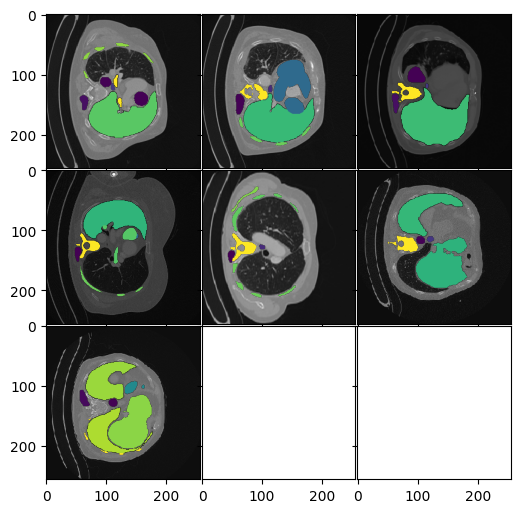

In [ ]:
def visu_label(index_img):
  nrows = len(index_img) //3 +1
  fig =plt.figure(figsize=(6,9))
  grid = ImageGrid(fig,111, (nrows,3))
  for ax,im in zip(grid, index_img):
    ax.imshow(dataset.imgs[im], cmap="gray")
    seg_masked = np.ma.masked_where(labels_train.iloc[im].values.reshape((256, 256)) == 0, (labels_train.iloc[im].values.reshape((256, 256))))
    ax.imshow(seg_masked)

visu_label(index_thorax)

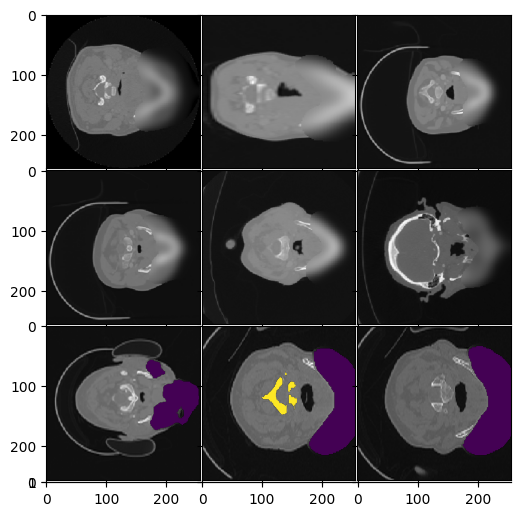

In [ ]:
visu_label(index_tete)

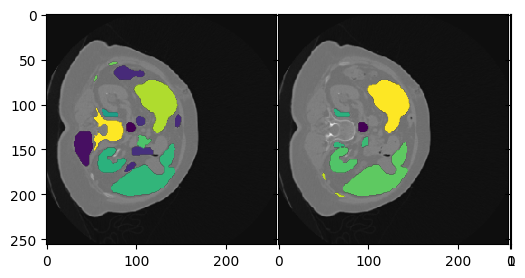

In [ ]:
visu_label(index_abdo4)

In [ ]:
for im in index_abdo4:
  print(np.unique(labels_train.iloc[im].values))

[ 0  3  5  9 10 31 35 36 39 42 47 53]
[ 0  3 31 32 33 35 36 43 47]


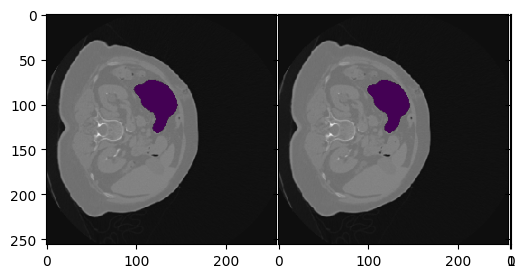

In [ ]:
visu_index(index_abdo4,47)

In [ ]:
for im in index_thorax:
  print(np.unique(labels_train.iloc[im].values))

[ 0  3  5 11 38 42 50]
[ 0  5 11 22 38 43 54]
[ 0  3  5 11 38 54]
[ 0  5 22 37 41 43 54]
[ 0  5 11 42 43 45 54]
[ 0  3 11 36 37 54]
[ 0  3  4 22 36 37 38 43]


In [ ]:
for im in index_tete:
  print(np.unique(labels_train.iloc[im].values))

[0]
[0]
[0]
[0]
[0]
[0]
[ 0 12]
[ 0 12 52]
[ 0 12]


In [ ]:
# Filtrer les lignes où au moins une colonne contient 12
filtered_data12 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('12').any(), axis=1)]


In [ ]:
# Filtrer les lignes où au moins une colonne contient 54
filtered_data54 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('54').any(), axis=1)]

# Afficher les résultats
print(filtered_data54)

         Pixel 0  Pixel 1  Pixel 2  Pixel 3  Pixel 4  Pixel 5  Pixel 6  \
13.png         0        0        0        0        0        0        0   
14.png         0        0        0        0        0        0        0   
23.png         0        0        0        0        0        0        0   
39.png         0        0        0        0        0        0        0   
42.png         0        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
782.png        0        0        0        0        0        0        0   
786.png        0        0        0        0        0        0        0   
791.png        0        0        0        0        0        0        0   
794.png        0        0        0        0        0        0        0   
799.png        0        0        0        0        0        0        0   

         Pixel 7  Pixel 8  Pixel 9  ...  Pixel 65526  Pixel 65527  \
13.png         0        0        0  ...   

In [ ]:
# Filtrer les lignes où au moins une colonne contient 47
filtered_data47 = labels_train[labels_train.apply(lambda row: row.astype(str).str.contains('47').any(), axis=1)]

# Afficher les résultats
print(filtered_data47)

         Pixel 0  Pixel 1  Pixel 2  Pixel 3  Pixel 4  Pixel 5  Pixel 6  \
0.png          0        0        0        0        0        0        0   
1.png          0        0        0        0        0        0        0   
7.png          0        0        0        0        0        0        0   
8.png          0        0        0        0        0        0        0   
9.png          0        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
756.png        0        0        0        0        0        0        0   
767.png        0        0        0        0        0        0        0   
772.png        0        0        0        0        0        0        0   
774.png        0        0        0        0        0        0        0   
777.png        0        0        0        0        0        0        0   

         Pixel 7  Pixel 8  Pixel 9  ...  Pixel 65526  Pixel 65527  \
0.png          0        0        0  ...   

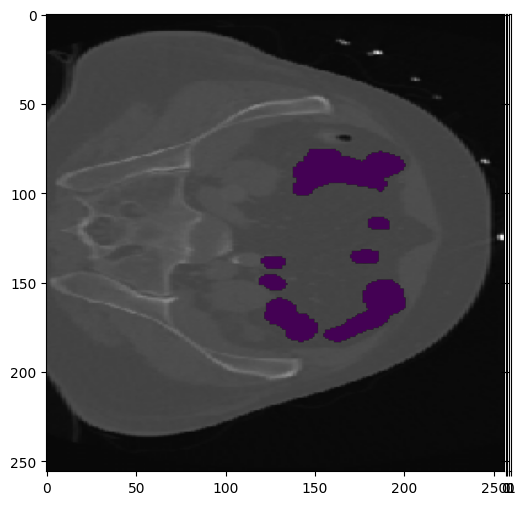

In [ ]:
visu_index([777],47)


# Utilisation du SwinUNet R


In [ ]:

# Reshape en (N, 256, 256)
masks = labels_train.values.reshape(-1, 256, 256)  # N = nombre d'images

print(f"Shape des masques : {masks.shape}")  # (N, 256, 256)


Shape des masques : (2000, 256, 256)


In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, img_dir, masks, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, '**/*.png'),recursive = True),key=alphanumeric_sort)
        self.masks = masks  # Masques déjà chargés
        self.transform = transform
        print(f"Nombre d'images : {len(self.img_paths)}")
        print(f"Nombre de masques : {self.masks.shape[0]}")


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)  # Charger image en niveaux de gris
        img = np.expand_dims(img, axis=0)  # Ajouter un canal

        mask = self.masks[idx].astype(np.float32)  # Récupérer le masque
        mask = np.expand_dims(mask, axis=0)  # Ajouter un canal

        if self.transform:
            img = self.transform(img)
            mask = torch.tensor(mask)  # Convertir en Tensor directement

        return img, mask



In [ ]:
import monai
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
)
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Appliquer les transformations
ttransforms = Compose([
    EnsureChannelFirst(),
    #ScaleIntensity(),
    #Resize((224, 224)),
    ToTensor()
])

# Créer dataset et dataloader
train_dataset = CTScanDataset(PATH + "train-images", masks, transform=ttransforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,drop_last=True)



Nombre d'images : 2000
Nombre de masques : 8


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(256, 256),
    in_channels=1,  # CT scans sont en niveaux de gris
    out_channels=1,  # Binaire (0 = normal, 1 = anomalie)
    feature_size=48,
    spatial_dims=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = monai.losses.DiceLoss(sigmoid=True)



/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


IndexError: index 83 is out of bounds for dimension 0 with size 8

In [ ]:
256/32

8.0

# Visualisation UMAP dont les embeddings sont proches du thorax à l'aide du DINOv2

Les colorés seront ceux du thorax et voir si entre eux ils sont proches et si oui, sélectionner les 20 plus proches et le visualiser




In [ ]:
#!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [ ]:

import torch
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import umap



In [ ]:
# Charger le modèle DINOv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
dinov2_vits14.eval()



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
# Transformation pour adapter les images à DINOv2
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Étendre à 3 canaux
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation DINOv2
])
train_path = PATH + "ex"
batch_size = 1
dataset = CTDataset(PATH + "train-images", transform=train_transform)
dl = DataLoader(dataset, batch_size=batch_size)


In [ ]:



# Fonction pour extraire les embeddings
def extract_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(dataloader):
            images = images.to(device)
            # Extraire les embeddings
            embedding = model(images)
            embeddings.append(embedding[0].cpu().numpy())
            labels.append(label)
    return np.vstack(embeddings), np.hstack(labels)


In [ ]:
train_embeddings, train_labels = extract_embeddings(dinov2_vits14, dl)

100%|██████████| 2000/2000 [12:04<00:00,  2.76it/s]


In [ ]:
#Créer une fonction qui conserve çela dans un csv avec Dask par exemple
import numpy as np
import pandas as pd

# Fonction pour sauvegarder les embeddings et labels dans un fichier CSV
def save_embeddings_to_csv(embeddings, labels, filename):
    # Créer un DataFrame
    data = pd.DataFrame(embeddings)
    data['label'] = labels  # Ajouter les labels comme dernière colonne
    # Sauvegarder dans un fichier CSV
    data.to_csv(filename, index=False)

# Sauvegarder les embeddings et labels pour train, valid, et test
#save_embeddings_to_csv(train_embeddings, train_labels, PATH + "train_embeddings_vits.csv")

In [ ]:
test_dataset = CTDataset(PATH + "test-images", transform=train_transform)
test_dataloader= DataLoader(test_dataset, batch_size=batch_size)

test_embeddings, test_labels = extract_embeddings(dinov2_vits14, test_dataloader)

100%|██████████| 500/500 [02:52<00:00,  2.89it/s]


In [ ]:
#save_embeddings_to_csv(test_embeddings, test_labels, PATH + "test_embeddings_vits.csv")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier avec k=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_embeddings, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predictions = knn.predict(test_embeddings)

In [ ]:
save_embeddings_to_csv(test_embeddings, predictions, PATH + "test_predictions_vits.csv")

In [ ]:
import pandas as pd
predictions = pd.read_csv(PATH + "test_predictions_vits.csv")

In [ ]:
np.unique(predictions["label"][170:175])

array(['/content/drive/MyDrive/Raidium_challenge/train-images/1301.png'],
      dtype='<U62')

In [ ]:
np.unique(predictions)

NameError: name 'np' is not defined

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_embeddings)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])

plt.title('UMAP projection', fontsize=24);

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3be78653d6ab>", line 2, in <cell line: 0>
    embedding = reducer.fit_transform(test_embeddings)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2928, in fit_transform
    self.fit(X, y, force_all_finite, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 2593, in fit
    ) = fuzzy_simplicial_set(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 566, in fuzzy_simplicial_set
    knn_indices, knn_dists, _ = nearest_neighbors(
                                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 315, in nearest_neighbors
    knn_indices = fast_knn_indices(X, n_neighbors)


In [ ]:

train_dataset=ImageFolder(train_path,transform=transform)
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True)

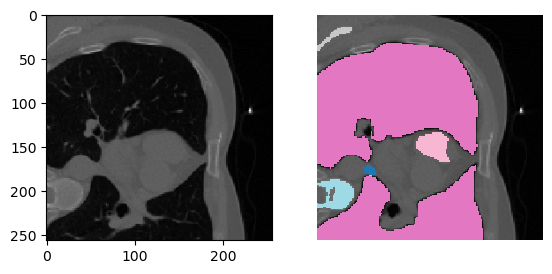

In [ ]:
plot_slice_seg(data_train[106], labels_train.iloc[106].values.reshape((256, 256)))

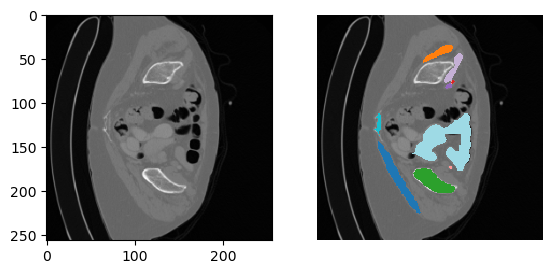

In [ ]:
plot_slice_seg(data_train[279], labels_train.iloc[279].values.reshape((256, 256)))

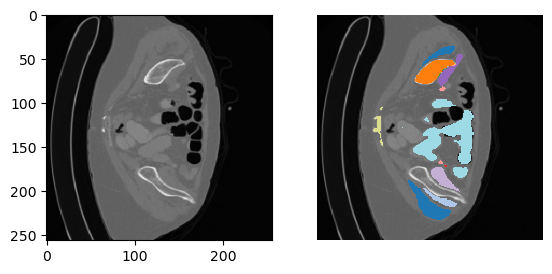

In [ ]:
plot_slice_seg(data_train[280], labels_train.iloc[280].values.reshape((256, 256)))

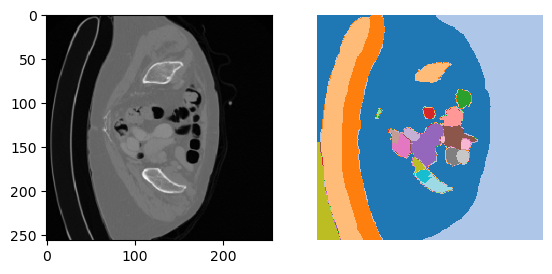

In [ ]:



# Updated baseline using Canny edge detector
def compute_baseline_one_sample(data_slice):
    # Apply Canny Edge Detector
    edges = cv2.Canny(data_slice, threshold1=10, threshold2=140)

    # Denoise and create markers
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]

    # Apply watershed
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

# Display the results
plot_slice_seg(data_train[279], compute_baseline_one_sample(data_train[279]))



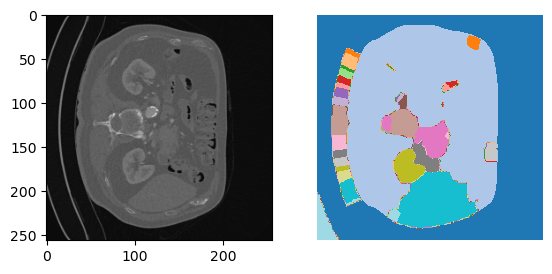

In [ ]:

# Updated baseline using Canny edge detector with preprocessing
def compute_baseline_one_sample(data_slice):
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(data_slice, (5, 5), 1.0)

    # Apply Canny Edge Detector with adjusted thresholds
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

    # Denoise with a larger disk and create markers
    denoised = rank.median(blurred, disk(3))
    markers = rank.gradient(denoised, disk(7)) < 15
    markers = ndi.label(markers)[0]

    # Apply watershed
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted


# Display the results
plot_slice_seg(data_train[21], compute_baseline_one_sample(data_train[21]))



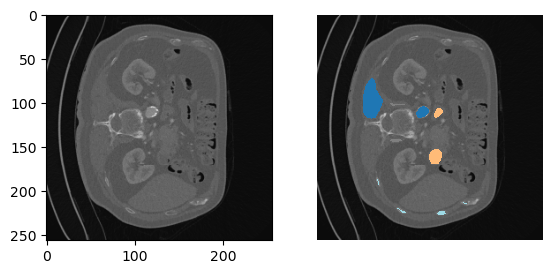

In [ ]:
plot_slice_seg(data_train[21], labels_train.iloc[21].values.reshape((256, 256)))

In [ ]:
"""# Performance Evaluation"""

def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

# Validation set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

# Compute baseline
labels_val_predicted_baseline = compute_baseline(data_val)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.11it/s]


In [ ]:

NUM_CLASSES = 54

def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))

def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1):
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))

# Compute metric
dice_pandas(labels_val, labels_val_predicted_baseline)


0.001099112352664831